In [18]:
import torch
import torch.nn as nn
from torch.distributions import Normal, Bernoulli
from torch.distributions.kl import kl_divergence
import numpy as np
import os

class FlowVAE(nn.Module):
    def __init__(self, img_size, dim_h, dim_z, decoder, flows=None):
        """
        normalizing flow model
        :param img_size: shape of the image
        :param dim_h: dimension of hidden states
        :param dim_z: dimension of latent variable
        :param decoder: decoder [BernoulliDecoder, LogitNormalDecoder]
        :param flows: Flows to transform output of base encoder
        """
        super().__init__()
        self.dim_z = dim_z
        self.img_size = img_size
        self.prior = Normal(0., 1.)
        self.encoder = nn.Sequential(nn.Linear(img_size[0]*img_size[1]*img_size[2], 2*dim_h), nn.ReLU(True), nn.Linear(2*dim_h, dim_h), nn.ReLU(True))
        self.mu = nn.Linear(dim_h, dim_z)
        self.var = nn.Linear(dim_h, dim_z)

        self.flows = nn.ModuleList(flows) if flows else None
        self.decoder = decoder

    def forward(self, x):
        """
        Takes data batch, samples num_samples for each data point from base distribution
        :param x: data
        :return: generated image and kl divergence
        """
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.var(x)

        # reparameterization
        sigma = torch.exp(0.5 * log_var)
        z = (mu + torch.randn_like(mu) * sigma) if self.training else mu
        q = Normal(mu, sigma)

        if self.flows:
            logq = q.log_prob(z)
            logq_k = -0.5 * torch.sum(2 * torch.log(sigma) + np.log(2 * np.pi) + ((z - mu) / sigma) ** 2, dim=1)
            for flow in self.flows:
                z, logq_k = flow(z, logq_k)
            kl = - torch.sum(self.prior.log_prob(z), dim=-1) + torch.sum(logq, dim=-1) - logq_k
        else:
            # standard VAE
            kl = kl_divergence(q, self.prior)

        # likelihood
        likelihood = self.decoder(z)
        return likelihood, kl

    def sample_img(self, deterministic=False):
        with torch.no_grad():
            z = torch.zeros(1, self.dim_z) if deterministic else torch.randn(1, self.dim_z)
            # The attribute probs is a little weird as we have to use it in Bernoulli. We desgin the variable of same name for LogitNormal
            out = self.decoder(z).probs
            out = out.reshape(-1, self.img_size[0], self.img_size[1], self.img_size[2])
        return out

    def save_model(self, save_path, epoch):
        if not os.path.exists(save_path): os.makedirs(save_path)
        torch.save(self.state_dict(), os.path.join(save_path, 'model_' + str(epoch) + '.pth'))
        print('Save Model to ' + save_path)

    def load_model(self, load_path, epoch, device="cpu"):
        if not os.path.exists(load_path): return
        self.load_state_dict(torch.load(os.path.join(load_path, 'model_' + str(epoch) + '.pth'), map_location=device))
        print('Load Model from ' + load_path)


class BernoulliDecoder(nn.Module):

    def __init__(self, img_size, dim_z, dim_h) -> None:
        super().__init__()
        self.decoder_nn = nn.Sequential(nn.Linear(dim_z, dim_h), nn.ReLU(True), nn.Linear(dim_h, 2*dim_h), nn.ReLU(True), nn.Linear(2*dim_h, img_size[0]*img_size[1]*img_size[2]))

    def forward(self, z):
        return Bernoulli(torch.sigmoid(self.decoder_nn(z)))


class LogitNormalDecoder(nn.Module):

    def __init__(self, img_size, dim_z, dim_h) -> None:
        super().__init__()
        self.decoder_nn = nn.Sequential(nn.Linear(dim_z, dim_h), nn.ReLU(True), nn.Linear(dim_h, 2*dim_h), nn.ReLU(True))
        self.mu = nn.Linear(2*dim_h, img_size[0]*img_size[1]*img_size[2])
        self.var = nn.Linear(2*dim_h, img_size[0]*img_size[1]*img_size[2])

    def forward(self, z):
        z = self.decoder_nn(z)
        mu = self.mu(z)
        log_var = self.var(z)
        sigma = torch.exp(0.5 * log_var)
        self.normal = Normal(mu, sigma)
        self.probs = torch.exp(self.normal.mean) / (1 + torch.exp(self.normal.mean))  # weird name
        return self

    def log_prob(self, x):
        logit_x = torch.log(x / (1 - x) + 1e-5)
        log_norm_prob = self.normal.log_prob(logit_x)
        return log_norm_prob - torch.log(x*(1 - x))

In [14]:
import os
import argparse
import torch
from torchvision import datasets, transforms
from tqdm import tqdm
import torch.optim as optim
from torch.distributions import MultivariateNormal
import numpy as np


def prepare_dataset(dataset_name, batch_size, train=True):
    data = {
        'mnist': datasets.MNIST('datasets', train=train, download=True, transform=transforms.Compose([transforms.ToTensor(), lambda x: (x > 0.5).type(x.type())])),
        'cifar10': datasets.MNIST('datasets', train=train, download=True, transform=transforms.Compose([transforms.ToTensor(), lambda x: (x > 0.5).type(x.type())]))
    }
    dataloader = torch.utils.data.DataLoader(data[dataset_name], batch_size=batch_size, shuffle=train)
    return dataloader


def train(model, dataset_name, beta=1, device='cpu', num_epoch=10):
    dataloader = prepare_dataset(dataset_name, batch_size)
    model = model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    for epoch in range(num_epoch):
        t = tqdm(enumerate(dataloader), total=len(dataloader))
        epoch_loss = []
        for i, (x, _) in t:
            # with torch.autograd.set_detect_anomaly(True):
            x = x.to(device)
            optimizer.zero_grad()
            x = x.reshape([-1, x.shape[1]*x.shape[2]*x.shape[3]])
            likelihood, kl = model(x)
            recon_loss_ = -likelihood.log_prob(x).sum() / len(x)
            kl_loss_ = kl.mean()
            loss = recon_loss_ + beta * kl_loss_
            loss.backward()
            epoch_loss.append(loss.item())
            min_ln_loss_ = min([val.sum() for val in -likelihood.log_prob(x)])
            max_ln_loss_ = max([val.sum() for val in -likelihood.log_prob(x)])
            min_kl_loss_ = kl.min()
            max_kl_loss_ = kl.max()
            t.set_description("Epoch %d, Recon loss %.3f (min-max %.3f %.3f), KL %.3f (min-max %.3f %.3f)" %
                              (epoch, recon_loss_, min_ln_loss_, max_ln_loss_,
                               kl_loss_, min_kl_loss_, max_kl_loss_))
            optimizer.step()

        if epoch and epoch % save_frequency == 0:
            model.save_model(save_path=save_path, epoch=epoch)
    return model

def train_energy(U, model, z_dim=2, batch_size=512, iteration=5000):
    """ Function for training on energy densities """

    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    t = tqdm(range(iteration))
    for it in t:
        optimizer.zero_grad()

        # prior
        prior = MultivariateNormal(torch.zeros(z_dim), torch.eye(z_dim))
        z = prior.rsample([batch_size])
        logq = prior.log_prob(z)

        for flow in model:
            z, logq = flow(z, logq)

        U_z = U(z)
        loss = torch.mean(U_z + logq)
        loss.backward()
        t.set_description("Loss %f" % loss)

        optimizer.step()
    return model


def test(model, dataset_name, num_flows, batch_size, epoch, beta=1.0):
    dataloader = prepare_dataset(dataset_name, batch_size, train=False)
    model.load_model(f"checkpoint/{dataset_name}/{num_flows}/{beta}", epoch)
    model.eval()
    t = tqdm(enumerate(dataloader), total=len(dataloader))
    recon_loss = []
    kl_loss = []
    for i, (x, _) in t:
        x = x.reshape([-1, x.shape[1]*x.shape[2]*x.shape[3]])
        with torch.no_grad():
            likelihood, kl = model(x)
        recon_loss_ = -likelihood.log_prob(x).sum() / len(x)
        kl_loss_ = kl.mean()
        recon_loss.append(recon_loss_)
        kl_loss.append(kl_loss_)
    return np.array(recon_loss).mean(), np.array(kl_loss).mean()

# Argument parser
# parser = argparse.ArgumentParser(description="Normalizing Flow VAE")
# parser.add_argument("--dataset", '-d', dest="dataset_name", default="mnist", type=str)
# parser.add_argument("--numflows", '-k', dest="num_flows", default=10, type=int)
# parser.add_argument("--epochs", '-e', dest="num_epoch", default=10, type=int)
# parser.add_argument("--beta", '-b', dest="beta", default=1, type=float)
dataset_name = 'mnist'
num_flows = 0
num_epoch = 50
beta = 1

# Input checking
assert dataset_name in ("mnist", "cifar10"), f"{dataset_name} is not valid dataset. Must be mnist or cifar10."

# Static hyperparameters
batch_size = 256
dim_z = 40
dim_h = 256
save_frequency = 10

# Derived hyperparameters
img_size = [1, 28, 28] if dataset_name == 'mnist' else [3, 32, 32]
save_path = os.path.join('./checkpoint', f'{dataset_name}/{num_flows}/{beta}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
decoder = BernoulliDecoder(img_size, dim_z, dim_h) if dataset_name == "mnist" else LogitNormalDecoder(img_size, dim_z, dim_h)

# assign flows if None, use standard VAE
# flows = [PlanarFlow(dim_z) for _ in range(num_flows)]

model = FlowVAE(img_size, dim_h, dim_z, decoder)
train(model, dataset_name, beta, device, num_epoch=num_epoch)

Epoch 0, Recon loss 127.180 (min-max 27.742 232.431), KL 2.283 (min-max 0.035 25.773): 100%|██████████| 235/235 [00:24<00:00,  9.40it/s] 
Epoch 1, Recon loss 76.435 (min-max 15.053 146.585), KL 3.005 (min-max 0.486 29.572): 100%|██████████| 235/235 [00:24<00:00,  9.59it/s] 
Epoch 2, Recon loss 63.392 (min-max 12.538 151.581), KL 3.096 (min-max 0.658 24.982): 100%|██████████| 235/235 [00:24<00:00,  9.62it/s]
Epoch 3, Recon loss 64.387 (min-max 6.829 189.474), KL 3.296 (min-max 0.627 28.447):   0%|          | 1/235 [00:00<00:25,  9.26it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 3, Recon loss 60.550 (min-max 7.316 151.691), KL 3.415 (min-max 0.750 25.245): 100%|██████████| 235/235 [00:24<00:00,  9.61it/s] 
Epoch 4, Recon loss 53.500 (min-max 8.409 121.810), KL 3.264 (min-max 0.860 20.781): 100%|██████████| 235/235 [00:21<00:00, 10.86it/s]
Epoch 5, Recon loss 50.289 (min-max 5.858 156.455), KL 3.288 (min-max 0.734 40.458):   1%|          | 2/235 [00:00<00:20, 11.51it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 5, Recon loss 46.074 (min-max 8.404 139.055), KL 3.447 (min-max 0.998 21.128): 100%|██████████| 235/235 [00:19<00:00, 11.78it/s]
Epoch 6, Recon loss 46.907 (min-max 3.551 106.840), KL 3.359 (min-max 1.022 20.191): 100%|██████████| 235/235 [00:19<00:00, 11.75it/s]
Epoch 7, Recon loss 43.271 (min-max 4.884 110.361), KL 3.373 (min-max 0.910 32.184):   1%|          | 2/235 [00:00<00:20, 11.41it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 7, Recon loss 44.293 (min-max 9.739 109.704), KL 3.435 (min-max 1.214 17.620): 100%|██████████| 235/235 [00:20<00:00, 11.74it/s]
Epoch 8, Recon loss 41.522 (min-max 2.803 119.529), KL 3.242 (min-max 1.133 24.065): 100%|██████████| 235/235 [00:19<00:00, 11.94it/s]
Epoch 9, Recon loss 38.023 (min-max 2.800 103.179), KL 3.332 (min-max 1.031 27.102):   1%|          | 2/235 [00:00<00:20, 11.25it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 9, Recon loss 38.494 (min-max 3.498 174.822), KL 3.357 (min-max 1.161 17.112): 100%|██████████| 235/235 [00:21<00:00, 10.71it/s]
Epoch 10, Recon loss 34.185 (min-max 4.830 73.857), KL 3.357 (min-max 1.193 18.287): 100%|██████████| 235/235 [00:19<00:00, 12.18it/s] 
Epoch 11, Recon loss 33.493 (min-max 1.305 101.330), KL 3.368 (min-max 1.086 16.830):   1%|          | 2/235 [00:00<00:19, 11.73it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 11, Recon loss 36.175 (min-max 0.856 87.388), KL 3.391 (min-max 1.121 18.601): 100%|██████████| 235/235 [00:19<00:00, 12.02it/s] 
Epoch 12, Recon loss 37.397 (min-max 3.727 103.463), KL 3.434 (min-max 1.461 17.207): 100%|██████████| 235/235 [00:19<00:00, 12.02it/s]
Epoch 13, Recon loss 32.921 (min-max 2.747 95.049), KL 3.428 (min-max 1.359 19.099):   1%|          | 2/235 [00:00<00:20, 11.63it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 13, Recon loss 29.951 (min-max 1.066 100.079), KL 3.324 (min-max 1.324 20.779): 100%|██████████| 235/235 [00:19<00:00, 11.98it/s]
Epoch 14, Recon loss 31.584 (min-max 2.604 85.278), KL 3.332 (min-max 1.321 19.181): 100%|██████████| 235/235 [00:19<00:00, 12.35it/s] 
Epoch 15, Recon loss 29.088 (min-max 1.412 94.576), KL 3.388 (min-max 1.314 24.509):   1%|          | 2/235 [00:00<00:19, 12.07it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 15, Recon loss 31.963 (min-max 1.606 87.441), KL 3.377 (min-max 1.380 30.978): 100%|██████████| 235/235 [00:19<00:00, 12.11it/s] 
Epoch 16, Recon loss 30.611 (min-max 2.797 106.456), KL 3.381 (min-max 1.359 17.352):   0%|          | 1/235 [00:00<00:26,  8.85it/s]

Epoch 16, Recon loss 29.583 (min-max 3.909 74.534), KL 3.295 (min-max 1.443 16.913): 100%|██████████| 235/235 [00:20<00:00, 11.73it/s] 
Epoch 17, Recon loss 29.023 (min-max 1.741 92.471), KL 3.343 (min-max 1.288 17.811):   1%|          | 2/235 [00:00<00:20, 11.50it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 17, Recon loss 27.644 (min-max 1.321 69.002), KL 3.328 (min-max 1.445 17.427): 100%|██████████| 235/235 [00:19<00:00, 11.80it/s] 
Epoch 18, Recon loss 27.773 (min-max 2.130 83.151), KL 3.404 (min-max 1.400 17.438): 100%|██████████| 235/235 [00:22<00:00, 10.57it/s] 
Epoch 19, Recon loss 26.206 (min-max 0.908 135.300), KL 3.401 (min-max 1.198 17.926):   0%|          | 1/235 [00:00<00:26,  8.88it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 19, Recon loss 26.585 (min-max 0.785 93.875), KL 3.300 (min-max 1.305 15.696): 100%|██████████| 235/235 [00:22<00:00, 10.32it/s] 
Epoch 20, Recon loss 26.511 (min-max 2.097 71.129), KL 3.364 (min-max 1.341 15.024): 100%|██████████| 235/235 [00:19<00:00, 11.88it/s] 
Epoch 21, Recon loss 27.490 (min-max 1.380 100.430), KL 3.321 (min-max 1.191 18.744):   1%|          | 2/235 [00:00<00:20, 11.52it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 21, Recon loss 25.047 (min-max 3.373 76.172), KL 3.357 (min-max 1.245 14.768): 100%|██████████| 235/235 [00:19<00:00, 11.86it/s] 
Epoch 22, Recon loss 28.772 (min-max 2.370 130.166), KL 3.487 (min-max 1.710 16.702): 100%|██████████| 235/235 [00:19<00:00, 11.86it/s]
Epoch 23, Recon loss 25.218 (min-max 0.753 121.014), KL 3.370 (min-max 1.375 19.798):   1%|          | 2/235 [00:00<00:20, 11.17it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 23, Recon loss 26.620 (min-max 0.434 84.426), KL 3.386 (min-max 1.335 15.392): 100%|██████████| 235/235 [00:19<00:00, 11.77it/s] 
Epoch 24, Recon loss 28.060 (min-max 2.309 102.329), KL 3.403 (min-max 1.476 22.777): 100%|██████████| 235/235 [00:20<00:00, 11.61it/s]
Epoch 25, Recon loss 24.692 (min-max 0.230 87.480), KL 3.360 (min-max 1.365 21.100):   1%|          | 2/235 [00:00<00:20, 11.27it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 25, Recon loss 25.020 (min-max 1.331 88.594), KL 3.365 (min-max 1.355 14.982): 100%|██████████| 235/235 [00:22<00:00, 10.25it/s] 
Epoch 26, Recon loss 23.535 (min-max 1.979 63.563), KL 3.373 (min-max 1.476 19.388): 100%|██████████| 235/235 [00:19<00:00, 11.77it/s] 
Epoch 27, Recon loss 22.224 (min-max 1.399 77.797), KL 3.355 (min-max 1.264 15.843):   1%|          | 2/235 [00:00<00:20, 11.47it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 27, Recon loss 25.523 (min-max 1.782 82.766), KL 3.439 (min-max 1.560 15.276): 100%|██████████| 235/235 [00:19<00:00, 11.89it/s] 
Epoch 28, Recon loss 26.492 (min-max 2.464 82.144), KL 3.414 (min-max 1.206 14.823): 100%|██████████| 235/235 [00:19<00:00, 12.31it/s] 
Epoch 29, Recon loss 24.097 (min-max 1.093 80.376), KL 3.385 (min-max 1.291 18.053):   0%|          | 1/235 [00:00<00:25,  9.12it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 29, Recon loss 24.689 (min-max 1.058 66.397), KL 3.336 (min-max 1.492 13.680): 100%|██████████| 235/235 [00:19<00:00, 11.86it/s] 
Epoch 30, Recon loss 26.744 (min-max 1.839 92.005), KL 3.398 (min-max 1.440 14.839): 100%|██████████| 235/235 [00:19<00:00, 12.00it/s] 
Epoch 31, Recon loss 23.667 (min-max 0.780 67.519), KL 3.445 (min-max 1.437 16.398):   1%|          | 2/235 [00:00<00:22, 10.47it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 31, Recon loss 23.893 (min-max 1.094 110.733), KL 3.402 (min-max 1.483 13.302): 100%|██████████| 235/235 [00:19<00:00, 11.85it/s]
Epoch 32, Recon loss 23.789 (min-max 2.334 63.193), KL 3.435 (min-max 1.569 17.409): 100%|██████████| 235/235 [00:19<00:00, 12.04it/s] 
Epoch 33, Recon loss 20.519 (min-max 0.946 52.469), KL 3.384 (min-max 1.367 18.066):   1%|          | 2/235 [00:00<00:20, 11.39it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 33, Recon loss 23.947 (min-max 1.174 70.236), KL 3.379 (min-max 1.497 14.426): 100%|██████████| 235/235 [00:19<00:00, 11.92it/s] 
Epoch 34, Recon loss 21.943 (min-max 0.385 64.657), KL 3.344 (min-max 1.355 14.676): 100%|██████████| 235/235 [00:19<00:00, 11.99it/s] 
Epoch 35, Recon loss 20.930 (min-max 0.636 62.766), KL 3.424 (min-max 1.537 15.770):   1%|          | 2/235 [00:00<00:20, 11.38it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 35, Recon loss 23.042 (min-max 2.504 53.621), KL 3.455 (min-max 1.559 15.977): 100%|██████████| 235/235 [00:22<00:00, 10.52it/s] 
Epoch 36, Recon loss 21.481 (min-max 1.028 76.942), KL 3.346 (min-max 1.396 12.708): 100%|██████████| 235/235 [00:20<00:00, 11.73it/s] 
Epoch 37, Recon loss 20.426 (min-max 0.521 72.481), KL 3.371 (min-max 1.406 14.053):   1%|          | 2/235 [00:00<00:20, 11.29it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 37, Recon loss 22.052 (min-max 1.033 71.459), KL 3.382 (min-max 1.547 15.852): 100%|██████████| 235/235 [00:20<00:00, 11.67it/s] 
Epoch 38, Recon loss 21.728 (min-max 0.870 68.187), KL 3.357 (min-max 1.493 15.553): 100%|██████████| 235/235 [00:20<00:00, 11.66it/s] 
Epoch 39, Recon loss 20.265 (min-max 0.638 66.079), KL 3.416 (min-max 1.275 14.879):   1%|          | 2/235 [00:00<00:21, 11.03it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 39, Recon loss 23.011 (min-max 0.916 82.573), KL 3.399 (min-max 1.523 14.196): 100%|██████████| 235/235 [00:19<00:00, 11.77it/s] 
Epoch 40, Recon loss 20.268 (min-max 0.536 52.429), KL 3.334 (min-max 1.288 14.397): 100%|██████████| 235/235 [00:19<00:00, 11.91it/s] 
Epoch 41, Recon loss 19.088 (min-max 0.354 60.521), KL 3.373 (min-max 1.245 14.366):   1%|          | 2/235 [00:00<00:20, 11.45it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 41, Recon loss 21.619 (min-max 0.949 59.773), KL 3.417 (min-max 1.515 14.104): 100%|██████████| 235/235 [00:19<00:00, 12.04it/s] 
Epoch 42, Recon loss 20.229 (min-max 0.379 66.842), KL 3.416 (min-max 1.439 14.910): 100%|██████████| 235/235 [00:19<00:00, 12.03it/s] 
Epoch 43, Recon loss 17.524 (min-max 0.416 62.648), KL 3.409 (min-max 1.248 16.311):   1%|          | 2/235 [00:00<00:19, 11.72it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 43, Recon loss 22.905 (min-max 3.504 70.779), KL 3.424 (min-max 1.258 19.327): 100%|██████████| 235/235 [00:19<00:00, 11.76it/s] 
Epoch 44, Recon loss 17.983 (min-max 0.243 60.908), KL 3.400 (min-max 1.444 17.283): 100%|██████████| 235/235 [00:20<00:00, 11.74it/s] 
Epoch 45, Recon loss 19.408 (min-max 0.431 67.215), KL 3.401 (min-max 1.369 17.297):   1%|          | 2/235 [00:00<00:19, 11.79it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 45, Recon loss 18.336 (min-max 0.522 59.568), KL 3.463 (min-max 1.398 13.515): 100%|██████████| 235/235 [00:19<00:00, 12.02it/s] 
Epoch 46, Recon loss 19.673 (min-max 1.162 52.404), KL 3.450 (min-max 1.637 15.435): 100%|██████████| 235/235 [00:19<00:00, 12.02it/s] 
Epoch 47, Recon loss 19.618 (min-max 0.677 67.349), KL 3.347 (min-max 1.381 15.794):   1%|          | 2/235 [00:00<00:22, 10.24it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 47, Recon loss 18.454 (min-max 1.329 43.218), KL 3.441 (min-max 1.484 14.452): 100%|██████████| 235/235 [00:20<00:00, 11.66it/s] 
Epoch 48, Recon loss 19.147 (min-max 0.494 76.310), KL 3.408 (min-max 1.336 22.069): 100%|██████████| 235/235 [00:20<00:00, 11.62it/s] 
Epoch 49, Recon loss 18.177 (min-max 0.517 59.130), KL 3.373 (min-max 1.296 18.698):   1%|          | 2/235 [00:00<00:20, 11.39it/s]

Save Model to ./checkpoint/mnist/0/1


Epoch 49, Recon loss 20.381 (min-max 1.108 62.256), KL 3.402 (min-max 1.628 15.546): 100%|██████████| 235/235 [00:20<00:00, 11.29it/s] 


FlowVAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
  )
  (mu): Linear(in_features=256, out_features=40, bias=True)
  (var): Linear(in_features=256, out_features=40, bias=True)
  (decoder): BernoulliDecoder(
    (decoder_nn): Sequential(
      (0): Linear(in_features=40, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=512, out_features=784, bias=True)
    )
  )
)

<All keys matched successfully>

In [40]:
def sample_img(model):    
    with torch.no_grad():
        z = torch.zeros(1, model.dim_z).cuda()
        # The attribute probs is a little weird as we have to use it in Bernoulli. We desgin the variable of same name for LogitNormal
        out = model.decoder(z).probs
        out = out.reshape(-1, model.img_size[0], model.img_size[1], model.img_size[2])
    return out

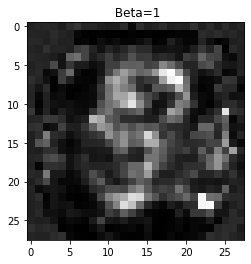

In [41]:
load_path = './checkpoint/mnist/0/1/model_48.pth'

device = torch.device('cpu')
model.load_state_dict(torch.load(load_path, map_location=device))

import matplotlib.pyplot as plt
for idx, model in enumerate([model]):
    img = sample_img(model)
    plt.imshow(img[0][0].cpu(), cmap='gray')
    plt.title(f' Beta={beta}')

plt.show()

In [44]:
import os
import argparse
import torch
from torchvision import datasets, transforms
from tqdm import tqdm
import torch.optim as optim
from torch.distributions import MultivariateNormal
import numpy as np


def prepare_dataset(dataset_name, batch_size, train=True):
    data = {
        'mnist': datasets.MNIST('datasets', train=train, download=True, transform=transforms.Compose([transforms.ToTensor(), lambda x: (x > 0.5).type(x.type())])),
        'cifar10': datasets.MNIST('datasets', train=train, download=True, transform=transforms.Compose([transforms.ToTensor(), lambda x: (x > 0.5).type(x.type())]))
    }
    dataloader = torch.utils.data.DataLoader(data[dataset_name], batch_size=batch_size, shuffle=train)
    return dataloader


def train(model, dataset_name, beta=1, device='cpu', num_epoch=10):
    dataloader = prepare_dataset(dataset_name, batch_size)
    model = model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    for epoch in range(num_epoch):
        t = tqdm(enumerate(dataloader), total=len(dataloader))
        epoch_loss = []
        for i, (x, _) in t:
            # with torch.autograd.set_detect_anomaly(True):
            x = x.to(device)
            optimizer.zero_grad()
            x = x.reshape([-1, x.shape[1]*x.shape[2]*x.shape[3]])
            likelihood, kl = model(x)
            recon_loss_ = -likelihood.log_prob(x).sum() / len(x)
            kl_loss_ = kl.mean()
            loss = recon_loss_ + beta * kl_loss_
            loss.backward()
            epoch_loss.append(loss.item())
            min_ln_loss_ = min([val.sum() for val in -likelihood.log_prob(x)])
            max_ln_loss_ = max([val.sum() for val in -likelihood.log_prob(x)])
            min_kl_loss_ = kl.min()
            max_kl_loss_ = kl.max()
            t.set_description("Epoch %d, Recon loss %.3f (min-max %.3f %.3f), KL %.3f (min-max %.3f %.3f)" %
                              (epoch, recon_loss_, min_ln_loss_, max_ln_loss_,
                               kl_loss_, min_kl_loss_, max_kl_loss_))
            optimizer.step()

        if epoch and epoch % save_frequency == 0:
            model.save_model(save_path=save_path, epoch=epoch)
    return model

def train_energy(U, model, z_dim=2, batch_size=512, iteration=5000):
    """ Function for training on energy densities """

    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    t = tqdm(range(iteration))
    for it in t:
        optimizer.zero_grad()

        # prior
        prior = MultivariateNormal(torch.zeros(z_dim), torch.eye(z_dim))
        z = prior.rsample([batch_size])
        logq = prior.log_prob(z)

        for flow in model:
            z, logq = flow(z, logq)

        U_z = U(z)
        loss = torch.mean(U_z + logq)
        loss.backward()
        t.set_description("Loss %f" % loss)

        optimizer.step()
    return model


def test(model, dataset_name, num_flows, batch_size, epoch, beta=1.0):
    dataloader = prepare_dataset(dataset_name, batch_size, train=False)
    model.load_model(f"checkpoint/{dataset_name}/{num_flows}/{beta}", epoch)
    model.eval()
    t = tqdm(enumerate(dataloader), total=len(dataloader))
    recon_loss = []
    kl_loss = []
    for i, (x, _) in t:
        x = x.reshape([-1, x.shape[1]*x.shape[2]*x.shape[3]])
        with torch.no_grad():
            likelihood, kl = model(x)
        recon_loss_ = -likelihood.log_prob(x).sum() / len(x)
        kl_loss_ = kl.mean()
        recon_loss.append(recon_loss_)
        kl_loss.append(kl_loss_)
    return np.array(recon_loss).mean(), np.array(kl_loss).mean()

# Argument parser
# parser = argparse.ArgumentParser(description="Normalizing Flow VAE")
# parser.add_argument("--dataset", '-d', dest="dataset_name", default="mnist", type=str)
# parser.add_argument("--numflows", '-k', dest="num_flows", default=10, type=int)
# parser.add_argument("--epochs", '-e', dest="num_epoch", default=10, type=int)
# parser.add_argument("--beta", '-b', dest="beta", default=1, type=float)
dataset_name = 'mnist'
num_flows = 0
num_epoch = 50
beta = 2

# Input checking
assert dataset_name in ("mnist", "cifar10"), f"{dataset_name} is not valid dataset. Must be mnist or cifar10."

# Static hyperparameters
batch_size = 256
dim_z = 40
dim_h = 256
save_frequency = 2

# Derived hyperparameters
img_size = [1, 28, 28] if dataset_name == 'mnist' else [3, 32, 32]
save_path = os.path.join('./checkpoint', f'{dataset_name}/{num_flows}/{beta}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
decoder = BernoulliDecoder(img_size, dim_z, dim_h) if dataset_name == "mnist" else LogitNormalDecoder(img_size, dim_z, dim_h)

# assign flows if None, use standard VAE
# flows = [PlanarFlow(dim_z) for _ in range(num_flows)]

model = FlowVAE(img_size, dim_h, dim_z, decoder)
train(model, dataset_name, beta, device, num_epoch=num_epoch)

Epoch 0, Recon loss 123.082 (min-max 24.755 223.292), KL 1.892 (min-max 0.000 24.610): 100%|██████████| 235/235 [00:20<00:00, 11.43it/s]
Epoch 1, Recon loss 83.742 (min-max 14.966 229.278), KL 2.345 (min-max 0.162 17.616): 100%|██████████| 235/235 [00:20<00:00, 11.48it/s] 
Epoch 2, Recon loss 72.132 (min-max 16.027 187.079), KL 2.404 (min-max 0.511 19.710): 100%|██████████| 235/235 [00:20<00:00, 11.68it/s]
Epoch 3, Recon loss 67.898 (min-max 8.295 177.153), KL 2.546 (min-max 0.474 21.255):   1%|          | 2/235 [00:00<00:20, 11.35it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 3, Recon loss 59.795 (min-max 10.542 151.422), KL 2.565 (min-max 0.704 13.525): 100%|██████████| 235/235 [00:20<00:00, 11.41it/s]
Epoch 4, Recon loss 49.705 (min-max 8.226 114.038), KL 2.617 (min-max 0.720 18.427): 100%|██████████| 235/235 [00:23<00:00, 10.09it/s] 
Epoch 5, Recon loss 52.062 (min-max 6.348 128.757), KL 2.687 (min-max 0.772 17.678):   0%|          | 1/235 [00:00<00:26,  9.00it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 5, Recon loss 45.481 (min-max 6.238 98.072), KL 2.700 (min-max 0.728 14.707): 100%|██████████| 235/235 [00:20<00:00, 11.26it/s] 
Epoch 6, Recon loss 39.204 (min-max 5.301 97.552), KL 2.693 (min-max 0.881 16.029): 100%|██████████| 235/235 [00:21<00:00, 10.90it/s] 
Epoch 7, Recon loss 44.310 (min-max 5.656 118.875), KL 2.678 (min-max 0.820 17.565):   0%|          | 1/235 [00:00<00:25,  9.18it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 7, Recon loss 44.365 (min-max 5.608 131.417), KL 2.756 (min-max 0.829 15.857): 100%|██████████| 235/235 [00:20<00:00, 11.53it/s]
Epoch 8, Recon loss 39.651 (min-max 3.502 138.193), KL 2.596 (min-max 0.819 13.668): 100%|██████████| 235/235 [00:20<00:00, 11.51it/s]
Epoch 9, Recon loss 41.789 (min-max 3.004 167.634), KL 2.706 (min-max 0.834 17.035):   1%|          | 2/235 [00:00<00:20, 11.37it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 9, Recon loss 42.421 (min-max 7.159 102.527), KL 2.815 (min-max 1.035 16.156): 100%|██████████| 235/235 [00:21<00:00, 11.14it/s]
Epoch 10, Recon loss 35.085 (min-max 3.681 92.001), KL 2.666 (min-max 0.805 20.581): 100%|██████████| 235/235 [00:24<00:00,  9.45it/s] 
Epoch 11, Recon loss 37.558 (min-max 3.995 109.220), KL 2.786 (min-max 0.830 13.878):   0%|          | 1/235 [00:00<00:25,  9.28it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 11, Recon loss 38.074 (min-max 2.434 140.529), KL 2.784 (min-max 0.718 13.302): 100%|██████████| 235/235 [00:23<00:00,  9.85it/s]
Epoch 12, Recon loss 33.407 (min-max 3.595 91.142), KL 2.736 (min-max 0.800 18.592): 100%|██████████| 235/235 [00:20<00:00, 11.44it/s] 
Epoch 13, Recon loss 34.983 (min-max 2.701 148.753), KL 2.736 (min-max 0.736 15.328):   1%|          | 2/235 [00:00<00:20, 11.34it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 13, Recon loss 31.372 (min-max 4.393 103.508), KL 2.763 (min-max 0.914 12.555): 100%|██████████| 235/235 [00:20<00:00, 11.43it/s]
Epoch 14, Recon loss 27.836 (min-max 2.473 90.132), KL 2.740 (min-max 0.714 12.220): 100%|██████████| 235/235 [00:20<00:00, 11.53it/s] 
Epoch 15, Recon loss 30.668 (min-max 2.216 107.020), KL 2.780 (min-max 0.734 12.965):   1%|          | 2/235 [00:00<00:20, 11.35it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 15, Recon loss 25.956 (min-max 2.630 84.689), KL 2.820 (min-max 1.028 14.242): 100%|██████████| 235/235 [00:20<00:00, 11.51it/s] 
Epoch 16, Recon loss 32.266 (min-max 1.999 80.581), KL 2.814 (min-max 0.753 15.550): 100%|██████████| 235/235 [00:20<00:00, 11.29it/s] 
Epoch 17, Recon loss 30.609 (min-max 1.390 98.033), KL 2.804 (min-max 0.721 16.260):   1%|          | 2/235 [00:00<00:20, 11.25it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 17, Recon loss 29.221 (min-max 1.622 111.318), KL 2.811 (min-max 0.727 11.826): 100%|██████████| 235/235 [00:20<00:00, 11.46it/s]
Epoch 18, Recon loss 27.526 (min-max 2.143 78.194), KL 2.698 (min-max 0.665 13.670): 100%|██████████| 235/235 [00:20<00:00, 11.48it/s] 
Epoch 19, Recon loss 28.845 (min-max 3.671 106.778), KL 2.705 (min-max 0.672 14.276):   1%|          | 2/235 [00:00<00:20, 11.35it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 19, Recon loss 28.539 (min-max 2.003 74.208), KL 2.850 (min-max 0.908 14.192): 100%|██████████| 235/235 [00:20<00:00, 11.61it/s] 
Epoch 20, Recon loss 26.541 (min-max 1.930 79.917), KL 2.834 (min-max 0.802 11.868): 100%|██████████| 235/235 [00:19<00:00, 11.87it/s] 
Epoch 21, Recon loss 26.179 (min-max 1.143 109.479), KL 2.815 (min-max 0.770 11.862):   0%|          | 1/235 [00:00<00:26,  8.90it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 21, Recon loss 27.824 (min-max 4.234 84.268), KL 2.891 (min-max 0.928 11.232): 100%|██████████| 235/235 [00:24<00:00,  9.44it/s] 
Epoch 22, Recon loss 24.725 (min-max 2.613 83.162), KL 2.791 (min-max 0.779 10.211): 100%|██████████| 235/235 [00:20<00:00, 11.55it/s] 
Epoch 23, Recon loss 25.263 (min-max 2.094 77.221), KL 2.841 (min-max 0.754 14.500):   0%|          | 1/235 [00:00<00:25,  9.03it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 23, Recon loss 24.533 (min-max 1.463 92.110), KL 2.822 (min-max 0.862 11.349): 100%|██████████| 235/235 [00:21<00:00, 10.75it/s] 
Epoch 24, Recon loss 27.854 (min-max 2.078 78.337), KL 2.793 (min-max 0.775 11.453): 100%|██████████| 235/235 [00:21<00:00, 10.79it/s] 
Epoch 25, Recon loss 23.524 (min-max 1.271 133.911), KL 2.790 (min-max 0.773 13.309):   1%|          | 2/235 [00:00<00:20, 11.36it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 25, Recon loss 23.995 (min-max 1.645 54.940), KL 2.791 (min-max 0.840 15.289): 100%|██████████| 235/235 [00:20<00:00, 11.48it/s] 
Epoch 26, Recon loss 25.294 (min-max 2.311 77.924), KL 2.853 (min-max 0.805 11.578): 100%|██████████| 235/235 [00:20<00:00, 11.48it/s] 
Epoch 27, Recon loss 22.810 (min-max 0.737 78.740), KL 2.845 (min-max 0.758 14.262):   1%|          | 2/235 [00:00<00:20, 11.37it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 27, Recon loss 25.458 (min-max 1.552 58.827), KL 2.918 (min-max 1.056 11.784): 100%|██████████| 235/235 [00:20<00:00, 11.44it/s] 
Epoch 28, Recon loss 26.860 (min-max 0.654 90.726), KL 2.877 (min-max 0.906 14.068): 100%|██████████| 235/235 [00:20<00:00, 11.41it/s] 
Epoch 29, Recon loss 22.848 (min-max 1.052 103.965), KL 2.853 (min-max 0.891 10.849):   1%|          | 2/235 [00:00<00:21, 10.67it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 29, Recon loss 24.043 (min-max 1.970 87.143), KL 2.910 (min-max 0.802 12.559): 100%|██████████| 235/235 [00:20<00:00, 11.28it/s] 
Epoch 30, Recon loss 22.609 (min-max 1.217 65.749), KL 2.833 (min-max 0.812 10.848): 100%|██████████| 235/235 [00:20<00:00, 11.21it/s] 
Epoch 31, Recon loss 21.294 (min-max 0.498 70.391), KL 2.843 (min-max 0.627 14.070):   1%|          | 2/235 [00:00<00:20, 11.25it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 31, Recon loss 23.822 (min-max 1.190 67.638), KL 2.861 (min-max 0.829 10.762): 100%|██████████| 235/235 [00:20<00:00, 11.50it/s] 
Epoch 32, Recon loss 24.273 (min-max 0.858 84.098), KL 2.918 (min-max 0.857 11.887): 100%|██████████| 235/235 [00:20<00:00, 11.67it/s] 
Epoch 33, Recon loss 21.891 (min-max 1.437 78.259), KL 2.881 (min-max 0.804 15.193):   1%|          | 2/235 [00:00<00:20, 11.60it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 33, Recon loss 22.026 (min-max 0.743 62.504), KL 2.849 (min-max 0.771 11.142): 100%|██████████| 235/235 [00:20<00:00, 11.46it/s] 
Epoch 34, Recon loss 21.466 (min-max 0.622 99.314), KL 2.872 (min-max 0.950 12.757): 100%|██████████| 235/235 [00:20<00:00, 11.38it/s] 
Epoch 35, Recon loss 21.089 (min-max 0.683 76.711), KL 2.874 (min-max 0.841 12.538):   0%|          | 1/235 [00:00<00:25,  9.11it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 35, Recon loss 23.210 (min-max 0.931 66.018), KL 2.862 (min-max 0.833 10.979): 100%|██████████| 235/235 [00:20<00:00, 11.30it/s] 
Epoch 36, Recon loss 20.558 (min-max 1.442 43.386), KL 2.867 (min-max 0.940 11.869): 100%|██████████| 235/235 [00:20<00:00, 11.36it/s] 
Epoch 37, Recon loss 20.824 (min-max 0.530 55.001), KL 2.885 (min-max 0.806 13.446):   1%|          | 2/235 [00:00<00:21, 10.88it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 37, Recon loss 22.512 (min-max 0.759 65.373), KL 2.914 (min-max 0.866 14.511): 100%|██████████| 235/235 [00:20<00:00, 11.61it/s] 
Epoch 38, Recon loss 22.917 (min-max 1.286 83.698), KL 2.910 (min-max 0.903 12.015): 100%|██████████| 235/235 [00:24<00:00,  9.53it/s] 
Epoch 39, Recon loss 19.734 (min-max 0.669 57.501), KL 2.821 (min-max 0.852 11.374):   0%|          | 1/235 [00:00<00:26,  8.77it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 39, Recon loss 21.251 (min-max 0.923 79.237), KL 2.873 (min-max 0.914 11.698): 100%|██████████| 235/235 [00:21<00:00, 10.99it/s] 
Epoch 40, Recon loss 20.945 (min-max 0.921 56.074), KL 2.941 (min-max 0.953 13.479): 100%|██████████| 235/235 [00:20<00:00, 11.57it/s] 
Epoch 41, Recon loss 20.235 (min-max 1.172 90.260), KL 2.879 (min-max 0.881 11.808):   1%|          | 2/235 [00:00<00:19, 11.87it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 41, Recon loss 20.076 (min-max 0.782 56.422), KL 2.932 (min-max 0.819 11.624): 100%|██████████| 235/235 [00:20<00:00, 11.43it/s] 
Epoch 42, Recon loss 21.246 (min-max 1.456 73.153), KL 2.932 (min-max 0.805 11.261): 100%|██████████| 235/235 [00:20<00:00, 11.75it/s] 
Epoch 43, Recon loss 19.993 (min-max 1.270 79.071), KL 2.869 (min-max 0.809 12.816):   1%|          | 2/235 [00:00<00:20, 11.48it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 43, Recon loss 18.086 (min-max 0.121 56.455), KL 2.894 (min-max 0.816 10.905): 100%|██████████| 235/235 [00:20<00:00, 11.46it/s] 
Epoch 44, Recon loss 18.849 (min-max 0.676 49.575), KL 2.894 (min-max 0.830 13.149): 100%|██████████| 235/235 [00:20<00:00, 11.52it/s] 
Epoch 45, Recon loss 19.475 (min-max 0.816 69.910), KL 2.916 (min-max 0.792 11.793):   1%|          | 2/235 [00:00<00:21, 10.91it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 45, Recon loss 20.106 (min-max 1.902 66.611), KL 2.933 (min-max 0.943 17.512): 100%|██████████| 235/235 [00:20<00:00, 11.70it/s] 
Epoch 46, Recon loss 20.895 (min-max 1.265 82.668), KL 2.927 (min-max 0.826 13.511): 100%|██████████| 235/235 [00:20<00:00, 11.33it/s] 
Epoch 47, Recon loss 19.587 (min-max 0.488 77.333), KL 2.905 (min-max 0.833 12.146):   0%|          | 1/235 [00:00<00:25,  9.08it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 47, Recon loss 20.729 (min-max 1.021 89.006), KL 2.953 (min-max 0.979 15.314): 100%|██████████| 235/235 [00:21<00:00, 10.97it/s] 
Epoch 48, Recon loss 18.388 (min-max 0.557 58.209), KL 2.924 (min-max 0.678 10.814): 100%|██████████| 235/235 [00:20<00:00, 11.48it/s] 
Epoch 49, Recon loss 19.242 (min-max 0.512 49.859), KL 2.965 (min-max 0.846 13.836):   1%|          | 2/235 [00:00<00:21, 11.00it/s]

Save Model to ./checkpoint/mnist/0/2


Epoch 49, Recon loss 19.185 (min-max 0.880 60.570), KL 2.905 (min-max 0.840 10.735): 100%|██████████| 235/235 [00:20<00:00, 11.55it/s] 


FlowVAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
  )
  (mu): Linear(in_features=256, out_features=40, bias=True)
  (var): Linear(in_features=256, out_features=40, bias=True)
  (decoder): BernoulliDecoder(
    (decoder_nn): Sequential(
      (0): Linear(in_features=40, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=512, out_features=784, bias=True)
    )
  )
)

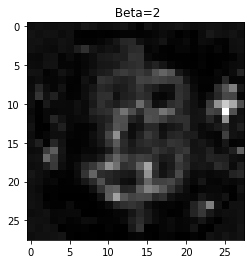

In [45]:
load_path = './checkpoint/mnist/0/2/model_48.pth'

device = torch.device('cpu')
model.load_state_dict(torch.load(load_path, map_location=device))

import matplotlib.pyplot as plt
for idx, model in enumerate([model]):
    img = sample_img(model)
    plt.imshow(img[0][0].cpu(), cmap='gray')
    plt.title(f' Beta={beta}')

plt.show()